<div class="alert alert-block alert-info">
<center> <h1> DEEP LEARNING MDSAA-BA 2021/2022 </h1> <center> <br>
<center> <h4> WEATHER IMAGE CLASSIFICATION PROJECT (GROUP 23)  <h4> <center>

**Table of Contents** <br>
* [1. Import Libraries](#import)
* [2. Data Rescale and Augmentation](#augmentation)
* [3. Callbacks Function](#callbacks)
* [4. Plotting Accuracy and Loss](#plot_acc_loss)
* [5. Classification Report](#class_report)
* [6. Models to Test](#models)
    * [6.1. Model 1](#model_1)
    * [6.2. Model 2](#model_2)
    * [6.3. Model 3](#model_3)
    * [6.4. Model 4](#model_4)
* [7. Comparing the Models](#compare_models)
* [8. Tuning of Best Model (Model 3)](#tuning)
* [9. Final Model ](#final_model)

<a class="anchor" id="import">

# 1. Import Libraries

</a>

In [72]:
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, GlobalMaxPool2D
import keras
from keras import callbacks

#!pip install -U scikit-learn
from sklearn.metrics import classification_report, confusion_matrix

# ! pip install matplotlib
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import sys
from PIL import Image
sys.modules['Image'] = Image


<a class="anchor" id="augmentation">

# 2. Data Rescale and Augmentation

</a>

In [73]:
# DATA AUGMENTATION --> this helps to expose the model to more aspects of the data

# Original images - RGB coefficients in the 0-255, but they are too high for our model to process
# We target values between 0 and 1 instead by scaling with a 1/255

train_data_gen = ImageDataGenerator(rescale=1 / 255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    # width_shift_range = 0.2,
                                    # height_shift_range = 0.2,
                                    # rotation_range = 15,
                                    # fill_mode = 'reflect',
                                    # data_format = 'channels_last',
                                    # brightness_range = [0.5, 1.5]
                                    )

# No modifications are made in the test set, except for rescaling
val_data_gen = ImageDataGenerator(rescale=1 / 255)


# Choose the batch size of train and validation, and also the target size of the images
batch_size = 16  # We can change this parameter
target_size = (100, 100)

training_set = train_data_gen.flow_from_directory('weather/data_train',
                                                  target_size=target_size,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)

validation_set = val_data_gen.flow_from_directory('weather/data_val',
                                                  target_size=target_size,
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=True)


Found 899 images belonging to 4 classes.
Found 167 images belonging to 4 classes.


<a class="anchor" id="callbacks">

# 3. Callbacks Function

</a>

In [74]:
def callbacks_list():
    
    # ReduceLROnPlateau
    lr = callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=5, min_lr=1e-30, cooldown=3, verbose=1)  

    # ModelCheckpoint
    cp = callbacks.ModelCheckpoint('modelos', monitor='accuracy', verbose=1, save_best_only=True, mode='auto')
    
    # EarlyStopping
    es = callbacks.EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)

    # Return list with all the callbacks
    return [lr, es, cp]


<a class="anchor" id="plot_acc_loss">

# 4. Plotting Accuracy and Loss

</a>

In [75]:
def plot_accuracy(hist):
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='lower right')
    plt.show()


def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.show()
    

<a class="anchor" id="class_report">

# 5. Classification Report

</a>

In [76]:
def evaluate_model(model):

    test_data_gen = ImageDataGenerator(rescale=1 / 255)

    test_set = val_data_gen.flow_from_directory('weather/data_test',
                                                 target_size=target_size,
                                                 batch_size=val_batch_size,
                                                 class_mode='categorical',
                                                 shuffle=False)
    
    filenames = test_set.filenames
    nb_samples = len(filenames)

    predict = model.predict_generator(test_set,steps = nb_samples)
    predicted_classes = predict.argmax(axis=-1)


    print(classification_report(test_set.classes, predicted_classes))
    print(confusion_matrix(test_set.classes, predicted_classes))
    

<a class="anchor" id="models">

# 6. Models to Test

</a>

<a class="anchor" id="model_1">

### 6.1 Model 1

</a>


In [77]:
model_1 = Sequential()

# Step 1
model_1.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (100, 100, 3), activation = 'relu'))

model_1.add(MaxPooling2D(pool_size = (2, 2))) # , strides=(2,2)

# Step 2
model_1.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))

model_1.add(MaxPooling2D(pool_size = (2, 2))) # , strides=(2,2)

# Step 3 - Global Max 
model_1.add(GlobalMaxPool2D())

# Step 4 - Full Connection
model_1.add(Dense(units = 128, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model_1.add(Dropout(0.2))
model_1.add(Dense(units = 256, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model_1.add(Dropout(0.2))
model_1.add(Dense(4, activation = 'softmax'))  


# Compiling the CNN
model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_1.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
global_max_pooling2d_11 (Glo (None, 64)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)             

In [79]:
# Fit the model - we can change the parameters
hist_model_1 = model_1.fit(training_set,
                           steps_per_epoch=training_set.n // batch_size,
                           epochs=100,
                           validation_data=validation_set,
                           validation_steps=validation_set.n // batch_size,
                           callbacks=callbacks_list()
                          )

In [ ]:
# Plot the accuracy and loss 
plot_accuracy(hist_model_1)
plot_loss(hist_model_1)

In [80]:
# Classification Report
evaluate_model(hist_model_1)

<a class="anchor" id="model_2">

### 6.2. Model 2

</a>


In [10]:
model_2 = Sequential()

# Step 1
model_2.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (100, 100, 3), activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2, 2))) # , strides=(2,2)

# Step 2
model_2.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2, 2))) # , strides=(2,2)

# Step 3
model_2.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2, 2))) # , strides=(2,2)

# Step 4 - Global Averaging
model_2.add(GlobalAveragePooling2D())

# Step 5 - Full connection
model_2.add(Dense(units = 256, activation = 'relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(4, activation = 'softmax'))  


# Compiling the CNN
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 128)              

In [11]:
# Fit the model - we can change the parameters
hist_model_2 = model_2.fit(training_set,
                           steps_per_epoch=training_set.n // batch_size,
                           epochs=100,
                           validation_data=validation_set,
                           validation_steps=validation_set.n // batch_size,
                           callbacks=callbacks_list()
                          )


Epoch 1/100
24/24 [==============================] - 11s 436ms/step - loss: 1.1283 - accuracy: 0.4947 - val_loss: 0.8251 - val_accuracy: 0.6125

Epoch 00001: accuracy improved from -inf to 0.49469, saving model to modelos
INFO:tensorflow:Assets written to: modelos\assets
Epoch 2/100
24/24 [==============================] - 8s 341ms/step - loss: 0.7896 - accuracy: 0.6393 - val_loss: 0.6895 - val_accuracy: 0.7563

Epoch 00002: accuracy improved from 0.49469 to 0.63926, saving model to modelos
INFO:tensorflow:Assets written to: modelos\assets
Epoch 3/100
24/24 [==============================] - 7s 308ms/step - loss: 0.6587 - accuracy: 0.7361 - val_loss: 0.7823 - val_accuracy: 0.6875

Epoch 00003: accuracy improved from 0.63926 to 0.73607, saving model to modelos
INFO:tensorflow:Assets written to: modelos\assets
Epoch 4/100
24/24 [==============================] - 9s 376ms/step - loss: 0.6024 - accuracy: 0.7586 - val_loss: 0.5546 - val_accuracy: 0.8000

Epoch 00004: accuracy improved from 


Epoch 00035: accuracy did not improve from 0.91645
Epoch 36/100
24/24 [==============================] - 10s 419ms/step - loss: 0.2662 - accuracy: 0.8966 - val_loss: 0.3089 - val_accuracy: 0.8938

Epoch 00036: accuracy did not improve from 0.91645
Epoch 37/100
24/24 [==============================] - 8s 323ms/step - loss: 0.2406 - accuracy: 0.9231 - val_loss: 0.3845 - val_accuracy: 0.9062

Epoch 00037: accuracy improved from 0.91645 to 0.92308, saving model to modelos
INFO:tensorflow:Assets written to: modelos\assets
Epoch 38/100
24/24 [==============================] - 9s 356ms/step - loss: 0.2648 - accuracy: 0.9138 - val_loss: 0.3688 - val_accuracy: 0.8750

Epoch 00038: accuracy did not improve from 0.92308
Epoch 39/100
24/24 [==============================] - 9s 387ms/step - loss: 0.2959 - accuracy: 0.8966 - val_loss: 0.2645 - val_accuracy: 0.9187

Epoch 00039: accuracy did not improve from 0.92308
Epoch 40/100
24/24 [==============================] - 10s 404ms/step - loss: 0.2010 

24/24 [==============================] - 8s 349ms/step - loss: 0.1140 - accuracy: 0.9602 - val_loss: 0.3763 - val_accuracy: 0.9125

Epoch 00073: accuracy did not improve from 0.97480
Epoch 74/100
24/24 [==============================] - 9s 393ms/step - loss: 0.0956 - accuracy: 0.9695 - val_loss: 0.3772 - val_accuracy: 0.9125

Epoch 00074: accuracy did not improve from 0.97480
Epoch 75/100
24/24 [==============================] - 9s 383ms/step - loss: 0.0879 - accuracy: 0.9655 - val_loss: 0.4086 - val_accuracy: 0.9000

Epoch 00075: accuracy did not improve from 0.97480
Epoch 76/100
24/24 [==============================] - 9s 359ms/step - loss: 0.0997 - accuracy: 0.9615 - val_loss: 0.4168 - val_accuracy: 0.9000

Epoch 00076: accuracy did not improve from 0.97480
Epoch 77/100
24/24 [==============================] - 10s 405ms/step - loss: 0.1079 - accuracy: 0.9668 - val_loss: 0.4137 - val_accuracy: 0.9000

Epoch 00077: accuracy did not improve from 0.97480
Epoch 00077: early stopping


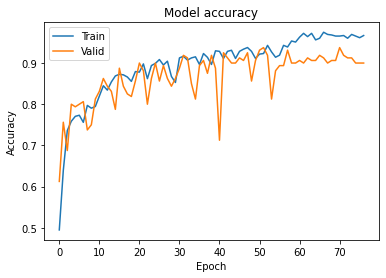

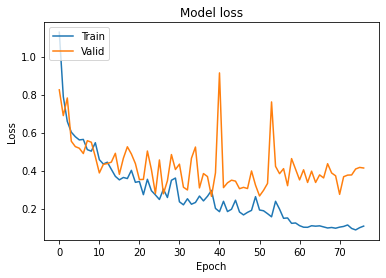

In [12]:
# Plot the accuracy and loss 
plot_accuracy(hist_model_2)
plot_loss(hist_model_2)

In [81]:
# Classification Report
evaluate_model(hist_model_2)

<a class="anchor" id="model_3">

### 6.3. Model 3

</a>


In [14]:
model_3 = Sequential()

# Step 1
model_3.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (100, 100, 3), activation = 'relu'))
model_3.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))

model_3.add(MaxPooling2D(pool_size = (2, 2))) # , strides=(2,2)

# Step 2
model_3.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model_3.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))

model_3.add(MaxPooling2D(pool_size = (2, 2))) # , strides=(2,2)

# Step 4 - Global Max
model_3.add(GlobalMaxPool2D())

# Step 5 - Full connection
model_3.add(Dense(units = 128, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model_3.add(Dense(4, activation = 'softmax'))  


# Compiling the CNN
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_3.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 64)               

In [15]:
# Fit the model - we can change the parameters
hist_model_3 = model_3.fit(training_set,
                           steps_per_epoch=training_set.n // batch_size,
                           epochs=100,
                           validation_data=validation_set,
                           validation_steps=validation_set.n // batch_size,
                           callbacks=callbacks_list()
                          )


Epoch 1/100
24/24 [==============================] - 14s 490ms/step - loss: 1.2147 - accuracy: 0.4973 - val_loss: 0.9954 - val_accuracy: 0.5813

Epoch 00001: accuracy improved from -inf to 0.49735, saving model to modelos
INFO:tensorflow:Assets written to: modelos\assets
Epoch 2/100
24/24 [==============================] - 11s 449ms/step - loss: 0.8558 - accuracy: 0.6286 - val_loss: 0.7744 - val_accuracy: 0.7063

Epoch 00002: accuracy improved from 0.49735 to 0.62865, saving model to modelos
INFO:tensorflow:Assets written to: modelos\assets
Epoch 3/100
24/24 [==============================] - 10s 427ms/step - loss: 0.7129 - accuracy: 0.7003 - val_loss: 0.7443 - val_accuracy: 0.7063

Epoch 00003: accuracy improved from 0.62865 to 0.70027, saving model to modelos
INFO:tensorflow:Assets written to: modelos\assets
Epoch 4/100
24/24 [==============================] - 10s 407ms/step - loss: 0.6281 - accuracy: 0.7334 - val_loss: 0.6863 - val_accuracy: 0.7125

Epoch 00004: accuracy improved fr

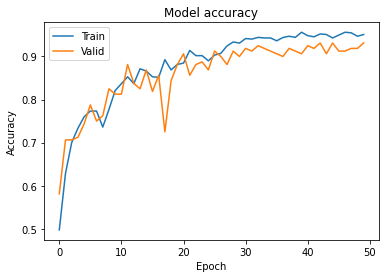

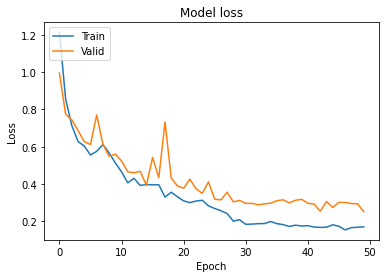

In [16]:
# Plot the accuracy and loss 
plot_accuracy(hist_model_3)
plot_loss(hist_model_3)

In [82]:
# Classification Report
evaluate_model(hist_model_3)

<a class="anchor" id="model_4">

### 6.4. Model 4

</a>


In [18]:
model_4 = Sequential()

# Step 1
model_4.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = (100, 100, 3), activation = 'relu'))
model_4.add(MaxPooling2D(pool_size = (2, 2))) # , strides=(2,2)

# Step 2
model_4.add(Conv2D(filters = 128, kernel_size = (3,3), activation = 'relu'))
model_4.add(MaxPooling2D(pool_size = (2, 2))) # , strides=(2,2)

# Step 3 - Global Average
model_4.add(GlobalAveragePooling2D())

# Step 5 - Full connection
model_4.add(Dense(units = 256, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model_4.add(Dropout(0.4))
model_4.add(Dense(units = 256, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model_4.add(Dropout(0.4))
model_4.add(Dense(4, activation = 'softmax'))  


# Compiling the CNN
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model_4.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 98, 64)        1792      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 47, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [19]:
# Fit the model - we can change the parameters
hist_model_4 = model_4.fit(training_set,
                           steps_per_epoch=training_set.n // batch_size,
                           epochs=100,
                           validation_data=validation_set,
                           validation_steps=validation_set.n // batch_size,
                           callbacks=callbacks_list()
                          )


Epoch 1/100
24/24 [==============================] - 13s 515ms/step - loss: 1.5583 - accuracy: 0.4509 - val_loss: 1.1889 - val_accuracy: 0.5250

Epoch 00001: accuracy improved from -inf to 0.45093, saving model to modelos
INFO:tensorflow:Assets written to: modelos\assets
Epoch 2/100
24/24 [==============================] - 11s 463ms/step - loss: 1.0910 - accuracy: 0.6340 - val_loss: 1.0604 - val_accuracy: 0.6438

Epoch 00002: accuracy improved from 0.45093 to 0.63395, saving model to modelos
INFO:tensorflow:Assets written to: modelos\assets
Epoch 3/100
24/24 [==============================] - 11s 469ms/step - loss: 0.9820 - accuracy: 0.6671 - val_loss: 0.9233 - val_accuracy: 0.6625

Epoch 00003: accuracy improved from 0.63395 to 0.66711, saving model to modelos
INFO:tensorflow:Assets written to: modelos\assets
Epoch 4/100
24/24 [==============================] - 12s 480ms/step - loss: 0.8372 - accuracy: 0.7215 - val_loss: 0.8382 - val_accuracy: 0.7312

Epoch 00004: accuracy improved fr

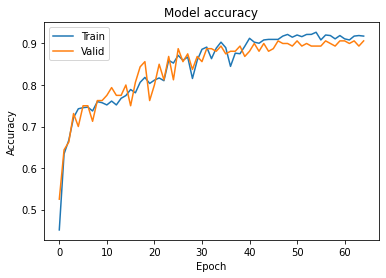

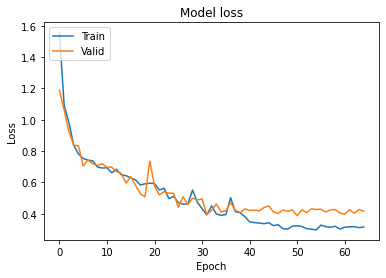

In [20]:
# Plot the accuracy and loss 
plot_accuracy(hist_model_4)
plot_loss(hist_model_4)

In [83]:
# Classification Report
evaluate_model(hist_model_4)

<a class="anchor" id="compare_models">

# 7. Comparing the Models 

</a>

In [66]:
def plot_accuracy_all(model1, model2, model3, model4):
    plt.plot(model1.history['val_accuracy'])
    plt.plot(model2.history['val_accuracy'])
    plt.plot(model3.history['val_accuracy'])
    plt.plot(model4.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Model_1_val', 'Model_2_val', 'Model_3_val', 'Model_4_val'], loc='lower right')
    plt.show()


def plot_loss_all(model1, model2, model3, model4):
    plt.plot(model1.history['val_loss'])
    plt.plot(model2.history['val_loss'])
    plt.plot(model3.history['val_loss'])
    plt.plot(model4.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Model_1_val', 'Model_2_val', 'Model_3_val', 'Model_4_val'], loc='upper right')
    plt.show
    

In [84]:
# Plot the 4 models together and compare the results
plot_accuracy_all(hist_model_1, hist_model_2, hist_model_3, hist_model_4)
plot_loss_all(hist_model_1, hist_model_2, hist_model_3, hist_model_4)

<a class="anchor" id="tuning">

# 8. Tuning of Best Model (Model 3)

</a>

In [57]:
model_3 = Sequential()

# Step 1
model_3.add(Conv2D(filters = 32, kernel_size = (3,3), input_shape = (100, 100, 3), activation = 'relu'))
model_3.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'))

model_3.add(MaxPooling2D(pool_size = (2, 2)))

# Step 2
model_3.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model_3.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))

model_3.add(MaxPooling2D(pool_size = (2, 2))) 

# Step 4 - Averaging
model_3.add(GlobalMaxPool2D())

# Step 5 - Full connection
model_3.add(Dense(units = 128, activation = 'relu', kernel_regularizer=regularizers.l2(0.001)))
model_3.add(Dropout(0.4))
model_3.add(Dense(4, activation = 'softmax'))  


# Compiling the CNN  # rmsprop
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_3.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
global_max_pooling2d_10 (Glo (None, 64)              

In [58]:
# Fit the model - we can change the parameters
hist_model_3 = model_3.fit(training_set,
                           steps_per_epoch=training_set.n // batch_size,
                           epochs=100,
                           validation_data=validation_set,
                           validation_steps=validation_set.n // batch_size,
                           callbacks=callbacks_list()
                          )

Epoch 1/100
56/56 [==============================] - 12s 209ms/step - loss: 1.7023 - accuracy: 0.4575 - val_loss: 1.3159 - val_accuracy: 0.5500

Epoch 00001: accuracy improved from -inf to 0.45753, saving model to modelos
INFO:tensorflow:Assets written to: modelos\assets
Epoch 2/100
56/56 [==============================] - 12s 213ms/step - loss: 1.1083 - accuracy: 0.6206 - val_loss: 0.9297 - val_accuracy: 0.6938

Epoch 00002: accuracy improved from 0.45753 to 0.62061, saving model to modelos
INFO:tensorflow:Assets written to: modelos\assets
Epoch 3/100
56/56 [==============================] - 12s 209ms/step - loss: 0.8493 - accuracy: 0.6829 - val_loss: 0.8114 - val_accuracy: 0.7125

Epoch 00003: accuracy improved from 0.62061 to 0.68290, saving model to modelos
INFO:tensorflow:Assets written to: modelos\assets
Epoch 4/100
56/56 [==============================] - 12s 208ms/step - loss: 0.7476 - accuracy: 0.6942 - val_loss: 0.7222 - val_accuracy: 0.7125

Epoch 00004: accuracy improved fr

56/56 [==============================] - 15s 259ms/step - loss: 0.2477 - accuracy: 0.9230 - val_loss: 0.3711 - val_accuracy: 0.9000

Epoch 00034: accuracy improved from 0.91733 to 0.92299, saving model to modelos
INFO:tensorflow:Assets written to: modelos\assets
Epoch 35/100
56/56 [==============================] - 15s 270ms/step - loss: 0.2534 - accuracy: 0.9252 - val_loss: 0.3332 - val_accuracy: 0.9000

Epoch 00035: accuracy improved from 0.92299 to 0.92522, saving model to modelos
INFO:tensorflow:Assets written to: modelos\assets
Epoch 36/100
56/56 [==============================] - 15s 267ms/step - loss: 0.2451 - accuracy: 0.9275 - val_loss: 0.3312 - val_accuracy: 0.9125

Epoch 00036: accuracy improved from 0.92522 to 0.92752, saving model to modelos
INFO:tensorflow:Assets written to: modelos\assets
Epoch 37/100
56/56 [==============================] - 15s 268ms/step - loss: 0.2440 - accuracy: 0.9128 - val_loss: 0.3633 - val_accuracy: 0.8875

Epoch 00037: accuracy did not improve f

56/56 [==============================] - 16s 280ms/step - loss: 0.1684 - accuracy: 0.9536 - val_loss: 0.2858 - val_accuracy: 0.9375

Epoch 00070: accuracy did not improve from 0.95696
Epoch 71/100
56/56 [==============================] - 16s 287ms/step - loss: 0.1732 - accuracy: 0.9468 - val_loss: 0.2460 - val_accuracy: 0.9438

Epoch 00071: accuracy did not improve from 0.95696
Epoch 72/100
56/56 [==============================] - 16s 286ms/step - loss: 0.1565 - accuracy: 0.9536 - val_loss: 0.3019 - val_accuracy: 0.9312

Epoch 00072: accuracy did not improve from 0.95696
Epoch 73/100
56/56 [==============================] - 16s 285ms/step - loss: 0.1778 - accuracy: 0.9490 - val_loss: 0.2969 - val_accuracy: 0.9312

Epoch 00073: accuracy did not improve from 0.95696
Epoch 74/100
56/56 [==============================] - 15s 275ms/step - loss: 0.1659 - accuracy: 0.9490 - val_loss: 0.2865 - val_accuracy: 0.9500

Epoch 00074: accuracy did not improve from 0.95696
Epoch 00074: early stopping


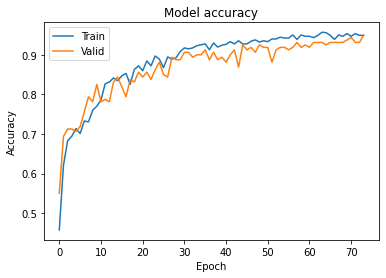

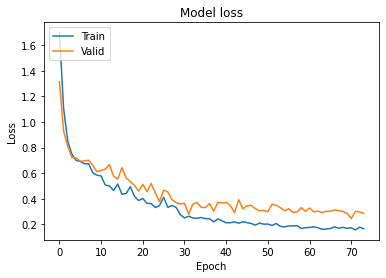

In [59]:
# Plot the accuracy and loss 
plot_accuracy(hist_model_3)
plot_loss(hist_model_3)

In [85]:
# Classification Report
evaluate_model(hist_model_3)

<a class="anchor" id="final_model">

# 9. Final Model 

</a>

In [68]:
# See the summary of the final model obtained
model_3.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
global_max_pooling2d_10 (Glo (None, 64)              